# Optimizing selections

### Goals:

1. To understand a real situation in which we are optimizing selection criteria to distinguish between "signal" and "background", in a search for elusive dark matter particles.
2. To wonder what these dark matter particles are anyway.
3. To understand the different between "covariance" and "correlation" and the advantages and disadvantages of each.
4. To deepen our understanding with examples of quantities that are highly correlated and quantities that are uncorrelated.

### Timing

1. Try to finish this notebook in 30-35 minutes. 

### Question and Answer Template

You can go to the link below, and do "file" -> "make a copy" to make yourself a google doc that you can use to fill in the answers to the question in this weeks notebooks.

https://docs.google.com/document/d/1_wdoM8-vNh09xbYAz1pKQAGNvl9LWtqt0cRruojHwXU/edit?usp=sharing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Hunting for dark matter in LUX-ZEPLIN

Only about 15% of the matter in the universe is composed of particles (electrons, protons, etc.) that scientists have been able to study in great detail. The other 85% is composed of an unknown, "dark" matter that can interact gravitationally, but whose other kinds of interactions aren't well understood.

There are a few different ways scientists can probe those other interactions of dark matter. Detectors like the LUX-ZEPLIN (LZ) detector below hope to "directly detect" dark matter by looking for rare scatters of dark matter particles on a target material. In LZ's case, a dark matter particle might very rarely smack into an atomic nucleus of one of the atoms within the detector (specifically, xenon). This produces flashes of light that can be detected, a so-called "S1" and "S2." The presence of one or both of these tells us that we have seen an interaction, or <b>"event"</b> occur within our detector volume.

<img src="figures/LZDetector.png" width="400"/>


However, just because we see an event, it doesn't mean we're certainly seeing dark matter interact. For example, an S1+S2 may instead be created by a random interaction of an ambient $\gamma$ ray (high energy photon) hitting our xenon atoms. So to search for dark matter interactions, it is first important to understand the difference between those so-called "background" events, and so-called "signal" events:



<b>Background:</b> These are events from known physics, that may mimic dark matter. Examples: $\gamma$-ray interactions, $\beta$ interactions, etc. Think of these as "boring" events, which we don't care about seeing.

<b>Signal:</b> These are possible dark matter or other "new physics" events. These are "interesting" events.


In LZ, signal and background events have different detection signatures that allow us to distinguish whether an event is due to signal or background. For example, S2s of background events are slightly more bright than S2s of signal events, because $\gamma$s and $\beta$s tend to smack into the atomic charge cloud instead of the xenon nucleus.

However, because the details of how the interactions create the S1 and S2 are messy, we cannot <i>perfectly</i> distinguish whether an individual event is signal or background. In other words, there's some fraction of background events that look more like signal events, and some fraction of signal events that look more like background events. This situation, where signal and backgrounds bleed together to some degree, is extremely common in event-based experiments. In this lab, we will explore the analysis methods used to do searches for rare signals under such conditions.

# !! Note: careful with time usage.

In this lab, we'll ask you some qualitative and quantitative questions about statistical methods for dark matter searches. Many of these can be answered in a single sentence or even a single number, so don't overthink them. Having enough time for the second lab this week is very important!

# Gathering Calibration Data
First, let's get a sense of what background data looks like. One way to get a sense of what background gamma or beta events look like is to do a calibration with some known $\beta$ source. Let's load in 100,000 events from a $\beta$ calibration source, and look at the sizes of the S2 flashes. There's a good deal of spread in these S2 sizes, so we typically look at the logarithm of the S2 size instead of the size itself, i.e. Log(S2).

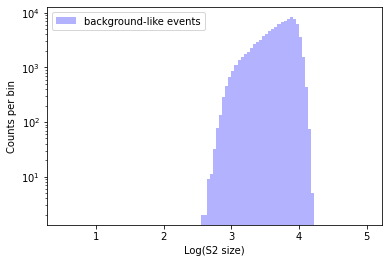

In [2]:
backgroundlike_calibration_data = np.loadtxt(open("../data/background_calibration_data.txt",'r'))


#Take the S2 values from the background-like calibration data and plot in a histogram. Each line is one event
backgroundlike_logS2Bins = np.linspace(0.5,5,100)
backgroundlike_logS2 = np.log10(backgroundlike_calibration_data[:])

#Plot these events 
plt.hist(backgroundlike_logS2, bins=backgroundlike_logS2Bins,fc=(0, 0, 1, 0.3),label="background-like events")
plt.xlabel(r'Log(S2 size)')
plt.ylabel(r'Counts per bin')
plt.yscale('log')
plt.legend()
plt.show()

Now, let's try to get a sense of what signal-like data will look like. As mentioned above, we expect dark matter scatters to look a bit different than $\gamma$ or $\beta$ scatters. Since humans haven't yet detected dark matter, we can't calibrate <i>with</i> real dark matter scatters. However, neutrons also smack into the nucleus of the atom, so we can shoot some neutrons into our detector to get a "signal-like" calibration dataset. Let's load in 100,000 of those.

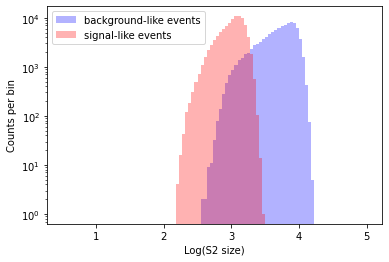

In [3]:
#Load in the neutron (signal-like) calibration events
signallike_calibration_data = np.loadtxt(open("../data/neutron_calibration_data.txt",'r'))

#Plot these on the same axes as the background-like calibration data
signallike_logS2 = np.log10(signallike_calibration_data[:])
plt.hist(backgroundlike_logS2, bins=backgroundlike_logS2Bins,fc=(0, 0, 1, 0.3),label="background-like events")
plt.hist(signallike_logS2, bins=backgroundlike_logS2Bins,fc=(1, 0, 0, 0.3),label="signal-like events")
plt.xlabel(r'Log(S2 size)')
plt.ylabel(r'Counts per bin')
plt.yscale('log')
plt.legend()
plt.show()

### Questions for Discussion
#### 1.1 What are we plotting in the above two plots? What does an individual entry in the blue histogram represent? What does an individual entry in the red histogram represent?

#### 1.2 The peaks of the two histograms are separated in Log(S2) space. What does this separation mean for our ability to distinguish background-like ($\beta$) events from signal-like (neutron) events?

#### 1.3 What do the widths of the two histograms mean? What does it mean that the histograms overlap a little bit? <b>Hint</b>: this overlap is what was previously referred to as "bleed" in the opening paragraph.

# Defining a background cut

Now we want to use these calibration datasets to come up with a "cut" to remove events that we know are extremely likely to be background-like. For simplicity, let's just cut away all events with Log(S2) above a certain value $X_{c}$. An example is below.

In [4]:
#Function we use to help us cut away events with S2s above a certain threshold cutVal
def CutEvents(eventList,cutVal):
    
    # make a mask of all events passing the cut
    mask = eventList < cutVal
    # apply that mask to the event list using the [] operation
    return eventList[mask]

<b>Note:</b> to change the cut value, you can modify the variable "cutValue_Xc" below. (You'll need to do this anyway for the next few questions!)

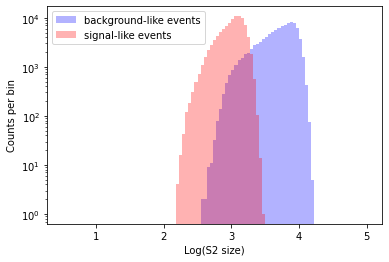

Number of signal-like event remaining after cut: 97713
Number of background-like events remaining after cut: 100000


In [9]:
#Define a cut value - play with this!
cutValue_Xc = 4.5


#Loop through elements and remove those above the cut value
signallike_logS2_afterCut = CutEvents(signallike_logS2,cutValue_Xc)
backgroundlike_logS2_afterCut = CutEvents(backgroundlike_logS2,cutValue_Xc)
        
plt.hist(backgroundlike_logS2_afterCut, bins=backgroundlike_logS2Bins,fc=(0, 0, 1, 0.3),label="background-like events")
plt.hist(signallike_logS2_afterCut, bins=backgroundlike_logS2Bins,fc=(1, 0, 0, 0.3),label="signal-like events")
plt.xlabel(r'Log(S2 size)')
plt.ylabel(r'Counts per bin')
plt.yscale('log')
plt.legend()
plt.show()

print(f"Number of signal-like event remaining after cut: {signallike_logS2_afterCut.size}")
print(f"Number of background-like events remaining after cut: {backgroundlike_logS2_afterCut.size}")

### Questions for discussion

#### 2.1 Play around with the cut value, $X_c$, to get a sense of what events remain if you change $X_c$. Include in your write-up two screenshots of this plot, each corresponding to a different cut value. Include with both plots the number of signal-like and background-like events remaining for that cut value.

#### 2.2 In the end, we will want a cut that removes background events but keeps signal (dark matter) events. If we are expecting our dark matter events to follow a distribution with the same shape as the red histogram, where do you think we might want to set our cut value?

# Acceptance, Leakage, and Optimizing our Cut

The real "art" to performing a dark matter (or rare event) search is in figuring out the best place to put a background cut. To quantify this a bit, we have to define two quantities:

<b>Signal-like event acceptance:</b> This is the fraction of signal-like events that remain once we cut away events above $X_{c}$. 

<b>Background-like event leakage:</b> This is the fraction of background-like events that remain once we cut away events above $X_{c}$.

The goal, then, is to try to minimize the background leakage while keeping the signal acceptance high. Let's illustrate this with some calculations.

### Questions

#### 3.1 In the code above, set $X_{c}$=2.0. How many true signal events do we accept with our cut? How many background events leak into our selection? What is the disadvantage of such a strict cut?

#### 3.2 In the code above, now set $X_{c}$=4.5. How many true signal events do we accept? How many background events leak into our selection? What is the disadvantage of such a relaxed cut? (Ryan's side note: due to a slight bug in my code this neutron dataset actually has 97,713 events, not 100,000 as originally claimed.)

In principle, we'll want a cut somewhere in between $X_{c}$=2.0 and $X_{c}$=4.5, and we'll want that cut informed by the signal acceptance and background leakage. We compute those below.

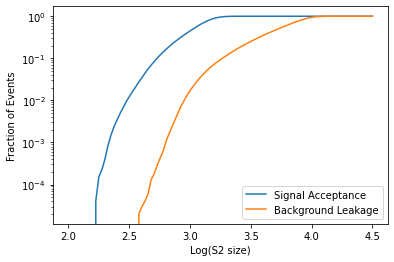

In [10]:
nPoints = 100
cutVal_list = np.linspace(2.0,4.5,nPoints)

signalAcceptance = np.zeros(nPoints)
backgroundLeakage = np.zeros(nPoints)
counter = 0
for cv in cutVal_list:
    signalAcceptance[counter] = (CutEvents(signallike_logS2,cv).size)
    backgroundLeakage[counter] = (CutEvents(backgroundlike_logS2,cv).size)
    counter += 1

signalAcceptance /= signallike_logS2.size
backgroundLeakage /= backgroundlike_logS2.size


plt.plot(cutVal_list,signalAcceptance, label=r"Signal Acceptance")
plt.plot(cutVal_list,backgroundLeakage, label=r"Background Leakage")
plt.yscale('log')
plt.xlabel(r'Log(S2 size)')
plt.ylabel(r'Fraction of Events')
plt.legend()
plt.show()

### Questions for discussion

#### 4.1 Suppose we set our cut at $X_{c}$=3.5. Based on these curves, what is the fraction of background events that will survive the cut? What is the fraction of signal events that will survive the cut?

Signal acceptance and background leakage curves are good tools to understand how to select cuts, because they describe how cuts affect the signal and background populations, independent of the normalizations those populations (i.e. how many signal/background events we have in total). However, these normalizations are important to consider in order to optimize our cut value.

#### 4.2 If my dark matter signal has the same distribution shape as the neutron calibration data, but we're only expecting 10 dark matter events total, on average how many dark matter events should survive a cut at $X_{c}$=3.5?

#### 4.3 If my background has the same distribution shape as the background calibration data, but we're expecting 200 background events total, on average how many background events should survive a cut at $X_{c}$=3.5?

#### 4.4 Assume a Poisson uncertainty in the surviving background events (i.e. the uncertainty is the square root of the number of surviving events). Given the number you found in 4.3, will a cut at $X_{c}$=3.5 allow us to confidently say that we've discovered dark matter in this scenario? Why or why not? Is there a way to better improve the sensitivity of our search?

#### 4.5 Using the answers to the last few questions, I want you to propose a cut value for $X_{c}$ that you think is best for confidently identifying whether we see dark matter events. Keep in mind that dark matter interactions are rare enough that none have been conclusively detected yet.